# Automatic Run with NEXT

This Notebook uses a pre-trained coefficient estimator to automatically generate temperature estimates for a given watershed.  Right now, the location has to be a USGS gage, but it doesn't have to have stream temperature.  A pre-processed geopackage of watershed boundaries (e.g., a nextgen hydrofabric subset) can also be used.

# Ultra-Short USGS Version

In [3]:
import warnings
with warnings.catch_warnings(action="ignore"):
    import NEXT
    (NEXT.NEXT.from_pickle("coefs.pickle").
     run(NEXT.data.full_data("10343500", "2015", "2024", weather="nldas")).
     plot(x="date", y="prediction"))

KeyError: 'Date&Time'

# General Setup

In [9]:
from NEXT import NEXT
from NEXT.data import all_data_gpkg, full_data
import NEXT.data as ndata
import warnings
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
gpkg_path = "clear_ck.geojson"

In [3]:
nx = NEXT.from_pickle("coefs.pickle")

# USGS Version

In [4]:
site = "10343500"  # Sagehen
name = "Sagehen Creek"
# site = "06719505"  # Clear Creek (Q, no T)
# name = "Clear Creek at Golden, CO"
# site = "02465000"  # Black Warrior R. (Q, no T) (National Water Center)
# name = "Black Warrior River near Tuscaloosa, AL"

Note that the server response may be a bit spotty here. If you see tracebacks about server responses/not found errors/etc, try rerunning it a few times. It may also be helpful to clear the HyRiver cache, which is probably a subdirectory here called `cache`.

In [12]:
fn = f"/scratch/dphilippus/notebooks/autorun/inputs_{site}.csv"
if os.path.exists(fn):
    ws_data = pd.read_csv(fn, parse_dates=["date"])
else:
    with warnings.catch_warnings(action="ignore"):  # upstream FutureWarning from pynldas
        ws_data = full_data(site, "2000", "2022", weather="nldas")  # daymet API is down
    ws_data.to_csv(fn, index=False)
ws_data["day"] = ws_data["date"].dt.dayofyear
ws_data

,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,elev,slope,elev_min,date,tmax,prcp,vp,canopy,ws_canopy,day
0,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2000-01-01,3.330,0.000000,348.681706,51.562496,51.562496,1
1,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2000-01-02,-1.340,0.087142,369.624859,51.562496,51.562496,2
2,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2000-01-03,3.870,0.000000,436.877162,51.562496,51.562496,3
3,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2000-01-04,2.610,0.010383,530.476220,51.562496,51.562496,4
4,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2000-01-05,1.555,0.000000,327.897610,51.562496,51.562496,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8396,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2022-12-27,6.180,2.720554,849.757026,48.144390,48.144390,361
8397,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2022-12-28,0.580,0.154500,502.795932,48.144390,48.144390,362
8398,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2022-12-29,0.075,0.070969,463.294612,48.144390,48.144390,363
8399,10343500,usgs,39.431546,-120.237955,2.525065e+07,0.0,0.000323,0.0,0.967676,0.027766,...,2163.070312,0.318227,1929.633545,2022-12-30,5.860,2.053871,862.463774,48.144390,48.144390,364


In [33]:
ws_data["slope"] = 0.03  # effect of slope goes absolutely insane

In [34]:
nx.make_newt(ws_data, use_drywet=True, reset=True)

In [35]:
nx.make_config(f"autoconf_{site}.yaml")

In [36]:
res = nx.run(ws_data)
res

,date,day,tmax,prcp,period,anomaly,ssn,output
0,2000-01-01,1,3.330,0.000000,1,-0.043942,1.959487,1.915546
1,2000-01-02,2,-1.340,0.087142,2,-0.091054,1.981505,1.890451
2,2000-01-03,3,3.870,0.000000,3,-0.317784,2.005918,1.688133
3,2000-01-04,4,2.610,0.010383,4,-0.179011,2.032678,1.853668
4,2000-01-05,5,1.555,0.000000,5,-0.263799,2.061740,1.797941
...,...,...,...,...,...,...,...,...
8396,2022-12-27,361,6.180,2.720554,361,0.908357,4.346596,5.254952
8397,2022-12-28,362,0.580,0.154500,362,0.725965,4.298397,5.024362
8398,2022-12-29,363,0.075,0.070969,363,0.335516,4.251609,4.587125
8399,2022-12-30,364,5.860,2.053871,364,0.229983,4.206246,4.436230


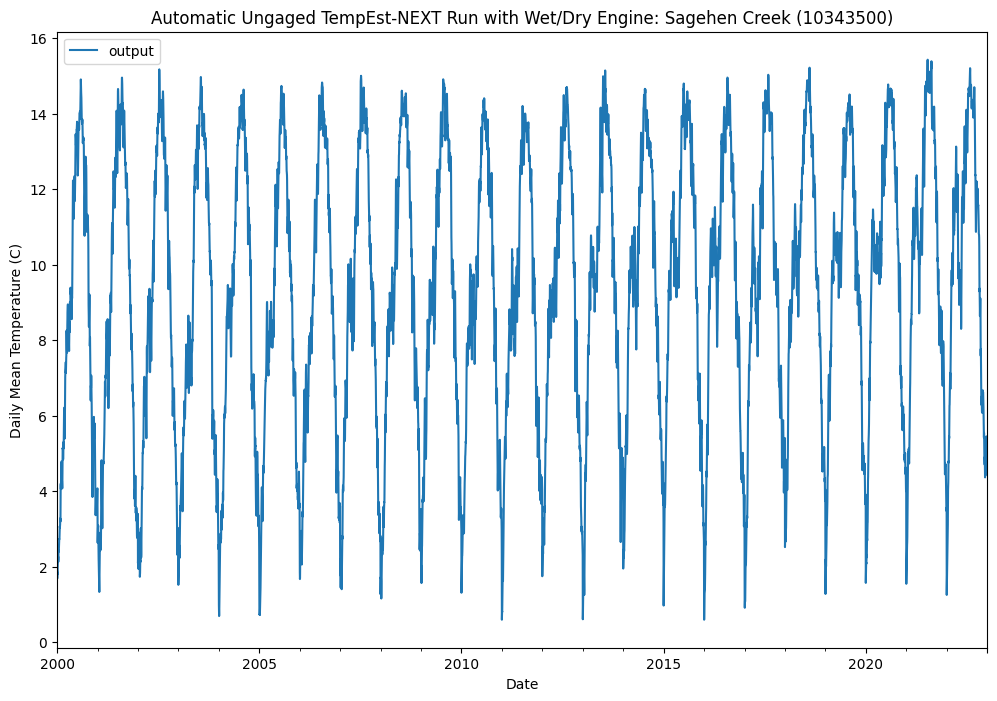

In [38]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
res.plot(x="date", y="output", ax=ax, title=f"Automatic Ungaged TempEst-NEXT Run with Wet/Dry Engine: {name} ({site})",
        xlabel="Date", ylabel="Daily Mean Temperature (C)")
plt.savefig(f"figures/UngagedAuto_{site}_drywet.png", dpi=1200, bbox_inches="tight")

# Geopackage Version

In [39]:
gpkg_path = "clear_ck.geojson"
out_root = "/u/wy/ch/dphilippus/hydrofcst/newtconf"

In [46]:
data_gen = all_data_gpkg(gpkg_path, "2015-01-01", "2019-12-31", weather='nldas', handler=lambda k, g, e: print(e))

In [ ]:
last_run = ""
with warnings.catch_warnings(action="ignore"):
    for (site, data) in data_gen:
        fn = f"{out_root}/{site}.yaml"
        try:
            if data is None:
                raise ValueError("Returned no data")
            data.loc[data["slope"] > 0.1, "slope"] = 0.1  # avoid weird slope behaviors
            data["day"] = data["date"].dt.dayofyear
            nx.make_newt(data, reset=True, use_climate=False)
            nx.newt.logfile = f"log{site}.txt"
            nx.make_config(fn)
            last_run = fn
        except Exception as e:
            print(f"No data: {site}. Error: {e}. Using: {last_run}.")
            shutil.copy(last_run, fn)